In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import utils as utils
import graphviz
import relabeling_pydl
from relabeling_pydl import Leaf

In [2]:

FILE_NAME = "relab_Lawsuit"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("../dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [3]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [4]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df


,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [5]:
for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1

In [6]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']
utils.discrimination(y, sensitive)

0.31205112598904444

In [7]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

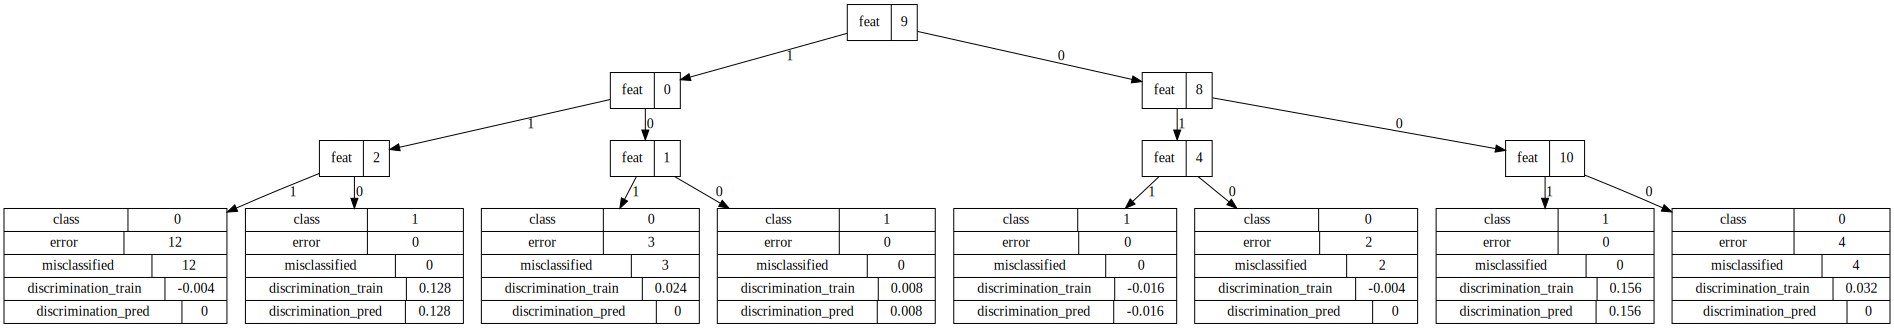

In [8]:
#clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=2,time_limit=600)
clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
cnt_unique = np.unique(sensitive_test, return_counts=True)[1]
y_pred_train = clf.predict(X_train)
utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)

dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)

In [9]:
import ast

y_pred_train = clf.predict(X_train)
discrimation_train = round(utils.discrimination(y_pred_train, sensitive_train), 8)
print(f"score: {clf.error_}")
print(f"acc: {round(accuracy_score(y_train, y_pred_train), 4)}")
print("Discrimination of classifier on train", discrimation_train)
print(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train'))
print(utils.sum_elem_tree(clf.tree_, 'misclassified'))

score: 21.0
acc: 0.8995
Discrimination of classifier on train 0.27704762
0.3256190476190477
21


In [10]:
from pprint import pprint

pprint(clf.tree_)

{'feat': 9,
 'left': {'feat': 0,
          'left': {'feat': 2,
                   'left': {'discrimination_additive_pred': 0.0,
                            'discrimination_additive_train': -0.0035238095238095193,
                            'error': 12.0,
                            'misclassified': 12,
                            'proba': [0.5714285714285714, 0.42857142857142855],
                            'transactions': [129,
                                             131,
                                             132,
                                             133,
                                             136,
                                             138,
                                             140,
                                             143,
                                             150,
                                             153,
                                             155,
                                             156,
               

In [11]:
result2 = pd.DataFrame(X_train, columns = X.columns)
result2["Class"] = y_train
result2["Sensitive"] = sensitive_train
result2["Pred"] = y_pred_train

In [12]:
relabeling_pydl.discrimination2(result2)

0.277047619047619

In [13]:
relabeling_pydl.discrimination(y_train, y_train, sensitive_train)

0.32561904761904753

In [14]:
utils.discrimination(y_train, sensitive_train)

0.32561904761904764

In [15]:
relabeling_pydl.discrimination(y_train, y_pred_train, sensitive_train)

0.277047619047619

In [16]:
utils.discrimination(y_pred_train, sensitive_train)

0.277047619047619

In [17]:
leafs = list()
cnt = np.unique(sensitive_train, return_counts=True)[1]
relabeling_pydl.leafs_to_relabel(clf.tree_, y_train, sensitive_train, cnt[0], cnt[1], leafs, len(y_train))
#print(utils.sum_elem_tree(clf.tree_, "disc",  s=list(), bool=False))
pprint(clf.tree_)

{'feat': 9,
 'left': {'feat': 0,
          'left': {'feat': 2,
                   'left': {'acc': -4,
                            'disc': -0.07457142857142858,
                            'discrimination_additive_pred': 0.0,
                            'discrimination_additive_train': -0.0035238095238095193,
                            'error': 12.0,
                            'misclassified': 12,
                            'proba': [0.5714285714285714, 0.42857142857142855],
                            'transactions': [129,
                                             131,
                                             132,
                                             133,
                                             136,
                                             138,
                                             140,
                                             143,
                                             150,
                                             153,
                  

In [18]:
for leaf in leafs:
    print(leaf)
    #print(f'd2: {leaf.disc2}')
    print()

Path: ((9, 'left'), (0, 'left'), (2, 'left')) 
accuracy: -0.01913875598086124 
discrimination: -0.07457142857142857 
ratio: 3.8963571428571435 
contigency: 
[0.04784688995215311, 0.023923444976076555]
[0.028708133971291867, 0.03349282296650718]

Path: ((9, 'left'), (0, 'left'), (2, 'right')) 
accuracy: -0.12440191387559808 
discrimination: -0.12838095238095237 
ratio: 1.031985347985348 
contigency: 
[0.0, 0.019138755980861243]
[0.0, 0.10526315789473684]

Path: ((9, 'left'), (0, 'right'), (1, 'right')) 
accuracy: -0.004784688995215311 
discrimination: -0.008 
ratio: 1.6720000000000002 
contigency: 
[0.0, 0.0]
[0.0, 0.004784688995215311]

Path: ((9, 'right'), (8, 'left'), (4, 'right')) 
accuracy: -0.07177033492822968 
discrimination: -0.06695238095238096 
ratio: 0.9328698412698412 
contigency: 
[0.04784688995215311, 0.004784688995215311]
[0.03349282296650718, 0.004784688995215311]

Path: ((9, 'right'), (8, 'right'), (10, 'left')) 
accuracy: -0.15311004784688997 
discrimination: -0.156476

In [19]:
##leafs_relab = relabeling.relab(clf.tree_, y_train, y_pred_train, sensitive_train, 0.2025)
leafs_relab = relabeling_pydl.relab(clf.tree_, y_train, y_pred_train, sensitive_train, 0)
print()
for leaf in leafs_relab:
    print(leaf)
    #print(f'd2: {leaf.disc2}')
    print()


Path: ((9, 'left'), (0, 'left'), (2, 'left')) 
accuracy: -0.01913875598086124 
discrimination: -0.07457142857142857 
ratio: 3.8963571428571435 
contigency: 
[0.04784688995215311, 0.023923444976076555]
[0.028708133971291867, 0.03349282296650718]

Path: ((9, 'left'), (0, 'right'), (1, 'right')) 
accuracy: -0.004784688995215311 
discrimination: -0.008 
ratio: 1.6720000000000002 
contigency: 
[0.0, 0.0]
[0.0, 0.004784688995215311]

Path: ((9, 'left'), (0, 'left'), (2, 'right')) 
accuracy: -0.12440191387559808 
discrimination: -0.12838095238095237 
ratio: 1.031985347985348 
contigency: 
[0.0, 0.019138755980861243]
[0.0, 0.10526315789473684]

Path: ((9, 'right'), (8, 'right'), (10, 'left')) 
accuracy: -0.15311004784688997 
discrimination: -0.15647619047619046 
ratio: 1.0219851190476188 
contigency: 
[0.0, 0.023923444976076555]
[0.0, 0.1291866028708134]



In [20]:
leafs_relab = relabeling_pydl.relab_leaf_limit(clf.tree_, y_train, y_pred_train, sensitive_train, 1)
print()
for leaf in leafs_relab:
    print(leaf)
    #print(f'd2: {leaf.disc2}')
    print()


Path: ((9, 'left'), (0, 'left'), (2, 'left')) 
accuracy: -0.01913875598086124 
discrimination: -0.07457142857142857 
ratio: 3.8963571428571435 
contigency: 
[0.04784688995215311, 0.023923444976076555]
[0.028708133971291867, 0.03349282296650718]



In [21]:

print(len(leafs_relab))
for leaf in leafs_relab:
    relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)
#clf.tree_

1


In [22]:
utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
discrimation_train = round(utils.discrimination(y_pred_train, sensitive_train),  8)
print(f"score: {clf.error_}")
print(f"acc: {round(accuracy_score(y_train, y_pred_train), 4)}")
print("Discrimination of classifier on train", discrimation_train)
print("Discrimination (relab) of classifier on train", round(relabeling_pydl.discrimination(y_train, y_pred_train, sensitive_train),  8))
print(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train'))
print(utils.sum_elem_tree(clf.tree_, 'misclassified'))

score: 21.0
acc: 0.8995
Discrimination of classifier on train 0.27704762
Discrimination (relab) of classifier on train 0.27704762
0.3256190476190477
21


In [23]:
import copy
k = 1000
depth = 4
random_state = 23
min_supp = 2

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
print(f"disc: {utils.discrimination(y_train, sensitive_train)}")

clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=600)
clf.fit(X_train, list(y_train))
# permet de fix
#clf.tree_["right"]["right"]["left"]['value'] = 1
y_pred_train = clf.predict(X_train)
accuracy_train = round(accuracy_score(y_train, y_pred_train),8)
discrimation_train_pred = round(relabeling_pydl.discrimination(y_train, y_pred_train, sensitive_train), 8)

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)

dot1 = utils.export_graphviz(clf)

leafs = list()
cnt_unique = np.unique(sensitive_train, return_counts=True)[1]

leafs_relab = relabeling_pydl.relab(clf.tree_, y_train, y_pred_train, sensitive_train, 0.23)
sum_acc = 0
sum_disc = 0
print(f'len leafs_relab {len(leafs_relab)}')
for leaf in leafs_relab:
    print(leaf)
    print()
    relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)
    sum_acc += leaf.acc
    sum_disc += leaf.disc
utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
dot2 = utils.export_graphviz(clf)


y_pred_train = clf.predict(X_train)
accuracy_train_relab = round(accuracy_score(y_train, y_pred_train), 8)
discrimation_train_pred_relab = round(relabeling_pydl.discrimination(y_train, y_pred_train, sensitive_train), 8)
new_acc= round(accuracy_train+sum_acc, 8)
new_disc = round(discrimation_train_pred+sum_disc, 8)
print(f"Accuracy:\n"
      f"    Before      : {accuracy_train}\n"
      f"    Leafs       : {sum_acc}\n"
      f"    After       : {accuracy_train_relab}\n"
      f"    Before+Leafs: {new_acc}\n"
      f"    Check       : {new_acc == accuracy_train_relab}\n"
      f"    Real diff   : {accuracy_train - accuracy_train_relab}")
print(f"Discrim:\n"
      f"    Before      : {discrimation_train_pred}\n"
      f"    Leafs       : {sum_disc }\n"
      f"    After       : {discrimation_train_pred_relab}\n"
      f"    Before+Leafs: {new_disc}\n"
      f"    Check       : {new_disc== discrimation_train_pred_relab}\n"
      f"    Real diff   : {discrimation_train_pred - discrimation_train_pred_relab}")
round(relabeling_pydl.discrimination(y_train, y_pred_train, sensitive_train), 6) == round(utils.discrimination(y_pred_train, sensitive_train), 6)

disc: 0.30694205393000573
len leafs_relab 1
Path: ((1, 'right'), (0, 'left'), (9, 'left'), (2, 'right')) 
accuracy: -0.014354066985645933 
discrimination: -0.023809523809523808 
ratio: 1.6587301587301586 
contigency: 
[0.0, 0.0]
[0.0, 0.014354066985645933]

Accuracy:
    Before      : 0.88038278
    Leafs       : -0.014354066985645933
    After       : 0.86602871
    Before+Leafs: 0.86602871
    Check       : True
    Real diff   : 0.014354069999999997
Discrim:
    Before      : 0.23905144
    Leafs       : -0.023809523809523808
    After       : 0.21524192
    Before+Leafs: 0.21524192
    Check       : True
    Real diff   : 0.02380952


True

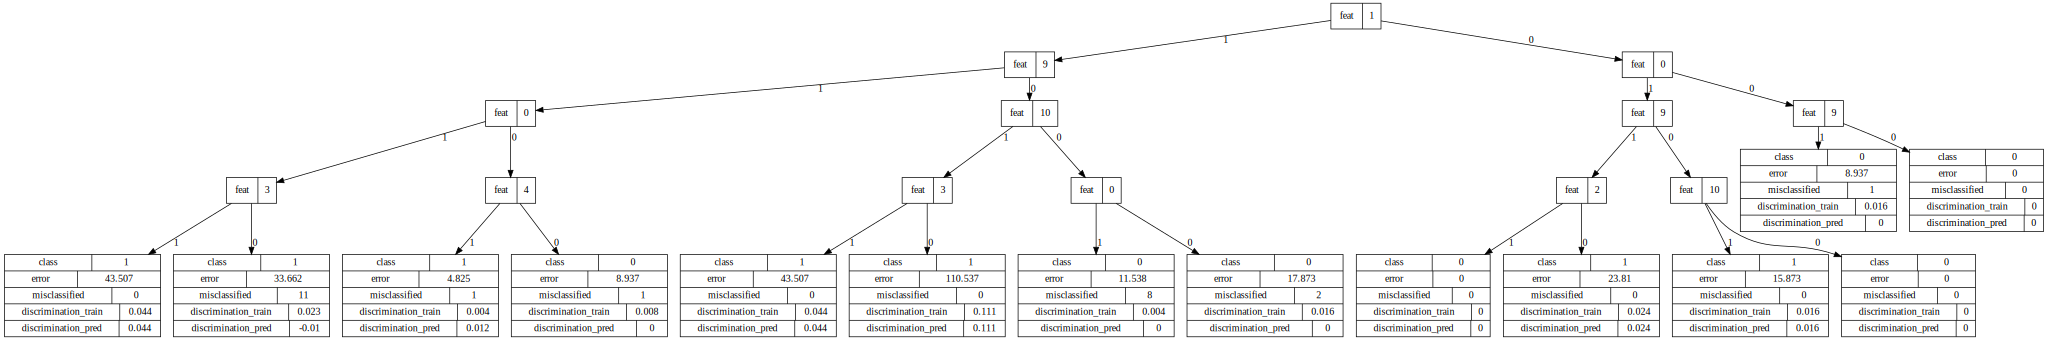

In [24]:
graphviz.Source(dot1)

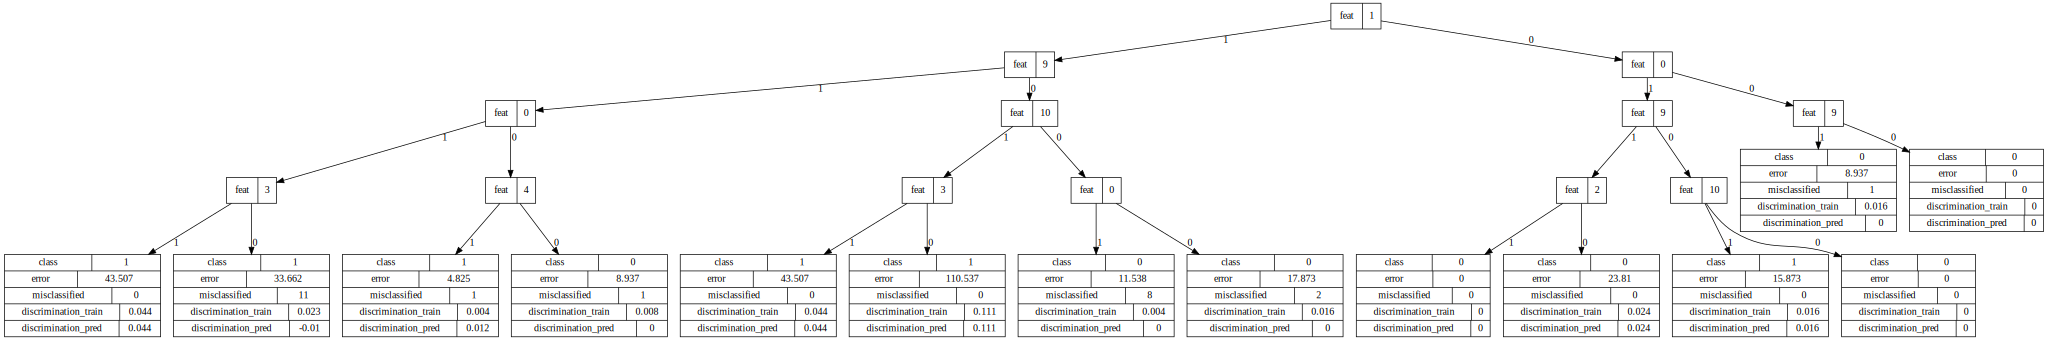

In [25]:
graphviz.Source(dot2)

In [26]:
clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=600)
clf.fit(X_train, list(y_train))
clf.tree_

{'feat': 1,
 'left': {'feat': 9,
  'left': {'feat': 0,
   'left': {'feat': 3,
    'left': {'value': 1,
     'error': 43.507362,
     'transactions': [167, 138, 143, 118, 121, 122, 124, 126],
     'proba': [0, 1.0]},
    'right': {'value': 1,
     'error': 33.662075,
     'transactions': [128,
      129,
      130,
      131,
      132,
      133,
      134,
      135,
      136,
      139,
      141,
      145,
      148,
      152,
      153,
      155,
      156,
      157,
      158,
      159,
      160,
      162,
      163,
      164,
      165,
      166,
      168,
      170,
      172,
      114,
      116,
      120,
      123,
      125],
     'proba': [0.3235294117647059, 0.6764705882352942]},
    'transactions': [128,
     129,
     130,
     131,
     132,
     133,
     134,
     135,
     136,
     138,
     139,
     141,
     143,
     145,
     148,
     152,
     153,
     155,
     156,
     157,
     158,
     159,
     160,
     162,
     163,
     164,
     165,

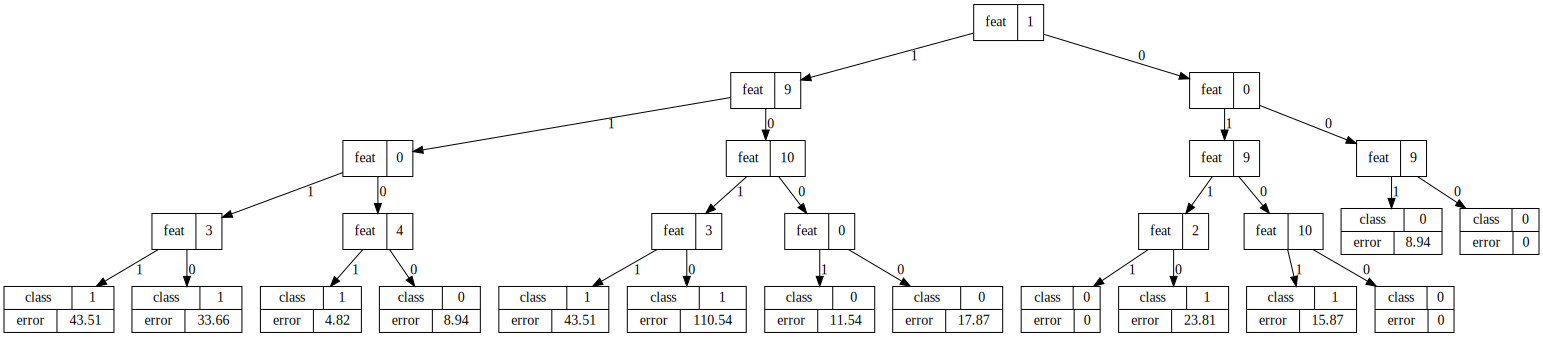

In [27]:
graphviz.Source(clf.export_graphviz())

In [28]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(13, X, y, sensitive)

clf = DL85Classifier(max_depth=2, error_function=lambda tids: utils.error(list(tids), 0, y_train, sensitive_train), min_sup=2, time_limit=600)

start = time.perf_counter()
clf.fit(X_train, list(y_train))
duration = time.perf_counter() - start
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

utils.tree_upgrade(clf.tree_, np.asarray(y_pred_train), np.asarray(y_pred_train), sensitive_train)
sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)
sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

discri_test= list()
utils.get_discri_test(clf.tree_, X_test, y_pred_test, sensitive_test, discri_test, X.columns, path=None)
sum_discrimination_additive_test_pred = sum(discri_test)
sum_discrimination_additive_test_pred_abs = 0
[sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]

print(discrimination_train_pred)
print(sum_discrimination_additive_train_pred)
print(sum_discrimination_additive_train_pred_abs)

0.31788204
0.31788204
0.31788204


In [29]:
leafs = list()
cnt_unique = np.unique(sensitive_train, return_counts=True)[1]

leafs_relab = relabeling_pydl.relab(clf.tree_, y_train, y_pred_train, sensitive_train, 0.0)
sum_acc = 0
sum_disc = 0
print(f'len leafs_relab {len(leafs_relab)}')
for leaf in leafs_relab:
    print(leaf)
    print()
    relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)


y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)
sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

discri_test= list()
utils.get_discri_test(clf.tree_, X_test, y_pred_test, sensitive_test, discri_test, X.columns, path=None)
sum_discrimination_additive_test_pred = sum(discri_test)
sum_discrimination_additive_test_pred_abs = 0
[sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]

print(discrimination_train_pred)
print(sum_discrimination_additive_train_pred)
print(sum_discrimination_additive_train_pred_abs)

len leafs_relab 2
Path: ((9, 'left'), (2, 'left')) 
accuracy: -0.019138755980861247 
discrimination: -0.13482193329564723 
ratio: 7.044446014697567 
contigency: 
[0.06220095693779904, 0.03827751196172249]
[0.028708133971291867, 0.03349282296650718]

Path: ((9, 'right'), (10, 'left')) 
accuracy: -0.14354066985645933 
discrimination: -0.18682871678914642 
ratio: 1.3015733936310534 
contigency: 
[0.0, 0.014354066985645933]
[0.0, 0.1291866028708134]

-0.00376861
-0.00376861
0.26587526


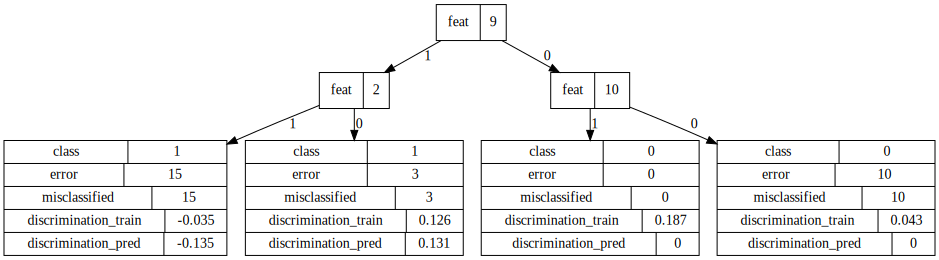

In [30]:
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)